In [301]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df_partitions = pd.read_csv("c3_muse_stress/metadata/partition.csv")
features_path = "c3_muse_stress/feature_segments"
labels_path = "c3_muse_stress/label_segments"

# Load a subject's data
def load_data(id):
    df_bpm = pd.read_csv(f'{features_path}/BPM/{id}.csv').drop(columns=['segment_id'])
    df_ecg = pd.read_csv(f'{features_path}/ECG/{id}.csv').drop(columns=['segment_id'])
    df_resp = pd.read_csv(f'{features_path}/resp/{id}.csv').drop(columns=['segment_id'])
    df_arousal = pd.read_csv(f'{labels_path}/arousal/{id}.csv').drop(columns=['segment_id'])
    df_valence = pd.read_csv(f'{labels_path}/valence/{id}.csv').drop(columns=['segment_id'])
    df_arousal.columns = ['timestamp', 'arousal']
    df_valence.columns = ['timestamp', 'valence']
    return df_bpm, df_ecg, df_resp, df_arousal, df_valence

def merge_dataframes(df_bpm, df_ecg, df_resp, df_arousal, df_valence, ma_window=50):
    df = pd.merge_asof(df_bpm, df_ecg, on='timestamp')
    df = pd.merge_asof(df, df_resp, on='timestamp')
    df = pd.merge_asof(df, df_arousal, on='timestamp')
    df = pd.merge_asof(df, df_valence, on='timestamp')
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['BPM_MA'] = df['BPM'].rolling(window=ma_window).mean()
    df['ECG_MA'] = df['ECG'].rolling(window=ma_window).mean()
    df['resp_MA'] = df['resp'].rolling(window=ma_window).mean()
    return df.dropna()

# Split data into train and devel
train_ids = df_partitions[df_partitions['Proposal'] == 'train']['Id']
devel_ids = df_partitions[df_partitions['Proposal'] == 'devel']['Id']

train_data = [merge_dataframes(*load_data(id)) for id in train_ids]
devel_data = [merge_dataframes(*load_data(id)) for id in devel_ids]

train_df = pd.concat(train_data)
devel_df = pd.concat(devel_data)

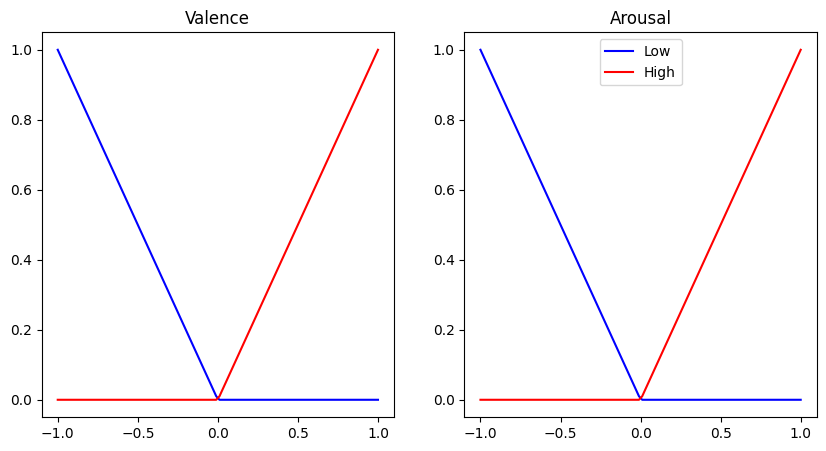

In [302]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

valence = np.linspace(-1, 1, 100)
arousal = np.linspace(-1, 1, 100)

# Define fuzzy membership functions for valence
valence_negative = fuzz.trimf(valence, [-1, -1, 0])
valence_positive = fuzz.trimf(valence, [0, 1, 1])

# Define fuzzy membership functions for arousal
arousal_negative = fuzz.trimf(arousal, [-1, -1, 0])
arousal_positive = fuzz.trimf(arousal, [0, 1, 1])

# Visualize these universes and membership functions
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

axs[0].plot(valence, valence_negative, 'b', linewidth=1.5, label='Negative')
axs[0].plot(valence, valence_positive, 'r', linewidth=1.5, label='Positive')
axs[0].set_title('Valence')
axs[1].plot(arousal, arousal_negative, 'b', linewidth=1.5, label='Low')
axs[1].plot(arousal, arousal_positive, 'r', linewidth=1.5, label='High')
axs[1].set_title('Arousal')
axs[1].legend()

fig.set_size_inches(10, 5)
plt.show()

In [303]:
# Fuzzification
valence_low = fuzz.interp_membership(valence, valence_negative, train_df.valence)
valence_high = fuzz.interp_membership(valence, valence_positive, train_df.valence)

arousal_low = fuzz.interp_membership(arousal, arousal_negative, train_df.arousal)
arousal_high = fuzz.interp_membership(arousal, arousal_positive, train_df.arousal)

# Fuzzy rules
rule_elation = np.fmin(valence_high, arousal_high)
rule_relaxed = np.fmin(valence_high, arousal_low)
rule_stress = np.fmin(valence_low, arousal_high)
rule_sad = np.fmin(valence_low, arousal_low)

# Rule set outputs
"""
The value received from this calculation will be in the interval [0,
1] and represent the degree of belonging of the current set of input
data to the specific emotion to which the rule corresponds.
Each rule will result in an output that is a set that is as follows. 

FR={a / elation, b / happy , c / relaxed, d / alert, e / neutral, f / tired, g / fear, h / stress, i / sad}

Where a, b, c, d, e, f, g, h, i are the values of the membership functions of the output variable emotion.
"""

f = np.zeros((train_df.shape[0], 4))

f[:, 0] = np.fmin(rule_elation, 1)
f[:, 1] = np.fmin(rule_relaxed, 1)
f[:, 2] = np.fmin(rule_stress, 1)
f[:, 3] = np.fmin(rule_sad, 1)

# Defuzzification
emotion = np.argmax(f, axis=1)

In [304]:
train_df['label'] = emotion
emotion_map = {
    3: 'elation',
    1: 'relaxed',
    1: 'stress',
    0: 'sad'
}
train_df['label_txt'] = train_df['label'].map(emotion_map)

In [305]:
import plotly.express as px

fig = px.scatter(train_df, x='valence', y='arousal', color='label')
fig.update_layout(width=800, height=500)
fig.show()

In [306]:
# fuzzyfy devel
valence_low = fuzz.interp_membership(valence, valence_negative, devel_df.valence)
valence_high = fuzz.interp_membership(valence, valence_positive, devel_df.valence)

arousal_low = fuzz.interp_membership(arousal, arousal_negative, devel_df.arousal)
arousal_high = fuzz.interp_membership(arousal, arousal_positive, devel_df.arousal)

# Fuzzy rules
rule_elation = np.fmin(valence_high, arousal_high)
rule_relaxed = np.fmin(valence_high, arousal_low)
rule_stress = np.fmin(valence_low, arousal_high)
rule_sad = np.fmin(valence_low, arousal_low)

# Rule set outputs
f = np.zeros((devel_df.shape[0], 9))

f[:, 0] = np.fmin(rule_elation, 1)
f[:, 1] = np.fmin(rule_relaxed, 1)
f[:, 2] = np.fmin(rule_stress, 1)
f[:, 3] = np.fmin(rule_sad, 1)

# Defuzzification
emotion = np.argmax(f, axis=1)

devel_df['label'] = emotion
devel_df['label_txt'] = devel_df['label'].map(emotion_map)


import plotly.express as px

fig = px.scatter(devel_df, x='valence', y='arousal', color='label')
fig.update_layout(width=800, height=500)
fig.show()


In [307]:
# train classifier

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_train = train_df[['BPM_MA', 'ECG_MA', 'resp_MA']]
y_train = train_df['label']

X_devel = devel_df[['BPM_MA', 'ECG_MA', 'resp_MA']]
y_devel = devel_df['label']

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_devel = scaler.transform(X_devel)

In [308]:
# train neural network classifier
import torch
import torch.nn as nn
import torch.optim as optim

class EmotionClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(EmotionClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout1 = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.dropout1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.dropout2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out
    
input_size = 3
hidden_size = 100
num_classes = 9
learning_rate = 0.001
num_epochs = 100

model = EmotionClassifier(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.long)

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

X_devel = torch.tensor(X_devel, dtype=torch.float32)
y_devel = torch.tensor(y_devel.values, dtype=torch.long)

model.eval()
with torch.no_grad():
    outputs = model(X_devel)
    _, predicted = torch.max(outputs, 1)
    print(f'Accuracy: {accuracy_score(y_devel, predicted)}')
    print(classification_report(y_devel, predicted))


Epoch [10/100], Loss: 1.876189112663269
Epoch [20/100], Loss: 1.5863202810287476
Epoch [30/100], Loss: 1.444743037223816
Epoch [40/100], Loss: 1.3958613872528076
Epoch [50/100], Loss: 1.3694442510604858
Epoch [60/100], Loss: 1.3575847148895264
Epoch [70/100], Loss: 1.341481328010559
Epoch [80/100], Loss: 1.3278789520263672
Epoch [90/100], Loss: 1.3212822675704956
Epoch [100/100], Loss: 1.314772605895996
Accuracy: 0.2885845917583824
              precision    recall  f1-score   support

           0       0.36      0.17      0.23      2321
           1       0.26      0.73      0.38      1758
           2       0.29      0.31      0.30      1453
           3       0.54      0.06      0.10      2282

    accuracy                           0.29      7814
   macro avg       0.36      0.32      0.25      7814
weighted avg       0.38      0.29      0.24      7814



In [309]:
train_df[train_df['label_txt'] == 'elation']

,timestamp,BPM,ECG,resp,arousal,valence,BPM_MA,ECG_MA,resp_MA,label,label_txt
49,1970-01-01 00:00:25.000,89.400055,0.161193,-1.978207,-0.2337,-0.3903,91.932075,0.022224,0.273933,3,elation
50,1970-01-01 00:00:25.500,89.592904,0.005619,-3.756008,-0.2385,-0.3952,91.902992,0.023232,0.227299,3,elation
51,1970-01-01 00:00:26.000,90.386637,-0.060541,-4.272635,-0.2459,-0.3993,91.941703,0.027231,0.192597,3,elation
52,1970-01-01 00:00:26.500,90.909091,-0.130547,-4.114565,-0.2555,-0.4009,92.026489,0.027281,0.189832,3,elation
53,1970-01-01 00:00:27.000,91.949650,-0.050484,-4.635593,-0.2669,-0.4020,92.160271,0.025783,0.181458,3,elation
...,...,...,...,...,...,...,...,...,...,...,...
524,1970-01-01 00:04:22.500,76.045627,-0.027553,0.206321,-0.0291,-0.0157,85.116676,0.005528,-0.050235,3,elation
525,1970-01-01 00:04:23.000,78.023407,-0.033445,0.373065,-0.0240,-0.0177,85.091909,0.004142,-0.043180,3,elation
526,1970-01-01 00:04:23.500,80.069685,0.046839,0.101065,-0.0185,-0.0196,85.058023,0.005253,-0.034785,3,elation
527,1970-01-01 00:04:24.000,81.841134,0.030792,0.381686,-0.0118,-0.0215,84.990300,0.008287,-0.031510,3,elation


In [310]:
def plot_label(label):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 6))
    axs[0, 0].hist(train_df[train_df['label_txt'] == label].BPM_MA, bins=20)
    axs[0, 0].set_title(f'BPM {label}')
    axs[0, 1].hist(train_df[train_df['label_txt'] == label].ECG_MA, bins=20)
    axs[0, 1].set_title(f'ECG {label}')
    axs[1, 0].hist(train_df[train_df['label_txt'] == label].resp_MA, bins=20)
    axs[1, 0].set_title(f'resp {label}')

    plt.show()

In [315]:
import plotly.graph_objects as go

# plot correlation matrix
corr = train_df[['BPM_MA', 'ECG_MA', 'resp_MA', 'arousal', 'valence', 'label']].corr()
fig = go.Figure(data=go.Heatmap(z=corr.values, x=corr.columns, y=corr.columns))
fig.show()